### 영어, 프랑스어, 독일어, 이탈리아어, 스페인어, 라틴어 구분 모델
- corpus : 성경 번역본 (-> 따라서, 모델이 성경에 특화됨)
- 단어사전 : 영어, 프랑스어, 독일어, 이탈리아어, 스페인어, 라틴어 모두 합쳐서 생성
- 데이터셋 : 원문 텍스트의 토큰화 수행, 인코딩된 결과를 제공
- 데이터로더 : 텐서화 수행한 결과와 offset 값을 제공
- 모델 : EmbeddingBag, Linear 사용

(1) 데이터 준비

In [2]:
import pandas as pd
import os, sys

In [3]:
# 1분 40초 걸림 (인내심을 요함)
engDF = pd.read_excel('data/English.xlsx')
freDF = pd.read_excel('data/French.xlsx')
gerDF = pd.read_excel('data/German.xlsx')
itaDF = pd.read_excel('data/Italian.xlsx')
spaDF = pd.read_excel('data/Spanish.xlsx')
latDF = pd.read_excel('data/Latin.xlsx')

In [4]:
# 'seg' 컬럼에 문장 존재
engDF.head(1)

,version,version2,h.title,respType,respName,wordCount,byteCount,units,distributor,eAddress,...,id3,id4,lang,id5,type,id6,type7,seg,id8,type9
0,4,2,Bible(ENG),Constructed in accordance to CES standards.,Christos Christodoulopoulos,789637,5412199,bytes,Bible Database,http://bibledatabase.com,...,utf-8,Bible,en,b.GEN,book,b.GEN.1,chapter,In the beginning God created the heaven and th...,b.GEN.1.1,verse


In [5]:
# itaDF만 'seg' 컬럼이 비정상
itaDF['seg'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 31292 entries, 0 to 31291
Series name: seg
Non-Null Count  Dtype 
--------------  ----- 
31280 non-null  object
dtypes: object(1)
memory usage: 244.6+ KB


In [6]:
# itaDF 에 결측치 존재
itaDF['seg'].isna().sum()

12

In [7]:
# seg 컬럼값이 na인 행만 삭제
itaDF.dropna(subset=['seg'], inplace=True)
len(itaDF)

31280

In [8]:
engDF.shape[0], freDF.shape[0], gerDF.shape[0], itaDF.shape[0], spaDF.shape[0]

(31102, 31102, 31102, 31280, 31100)

In [9]:
import numpy as np

# 피처 생성
featureNP = np.concatenate([engDF['seg'].values,
                           freDF['seg'].values,
                           gerDF['seg'].values,
                           itaDF['seg'].values,
                           spaDF['seg'].values,
                           latDF['seg'].values])
print(featureNP.shape)

(186897,)


In [10]:
# 타겟 생성
targetNP = np.array(['eng'] * engDF.shape[0]
                    + ['fre'] * freDF.shape[0]
                    + ['ger'] * gerDF.shape[0]
                    + ['ita'] * itaDF.shape[0]
                    + ['spa'] * spaDF.shape[0]
                    + ['lat'] * latDF.shape[0])
print(targetNP.shape)

# np.repeat(['a'], 10)

(186897,)


In [11]:
engDF['seg'].values

array(['In the beginning God created the heaven and the earth.',
       'And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.',
       'And God said, Let there be light: and there was light.', ...,
       'And if any man shall take away from the words of the book of this prophecy, God shall take away his part out of the book of life, and out of the holy city, and from the things which are written in this book.',
       'He which testifieth these things saith, Surely I come quickly. Amen. Even so, come, Lord Jesus.',
       'The grace of our Lord Jesus Christ be with you all. Amen.'],
      dtype=object)

In [12]:
from sklearn.model_selection import train_test_split

### 훈련, 검증, 테스트 데이터셋으로 분리
x_train, x_test, y_train, y_test = train_test_split(featureNP, targetNP, 
                                                    test_size=0.2, stratify=targetNP)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                    test_size=0.125, stratify=y_train)

In [13]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(130827,) (130827,)
(18690,) (18690,)
(37380,) (37380,)


In [14]:
# 배열에서 고유한 값과 빈도를 계산
unique_values, counts = np.unique(y_train, return_counts=True)

# 결과 출력
print(f'train 데이터셋의 크기 : {len(y_train)}')
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

train 데이터셋의 크기 : 130827
eng: 21771
fre: 21771
ger: 21771
ita: 21896
lat: 21848
spa: 21770


(2) 단어사전 생성

In [15]:
from nltk.corpus import stopwords

In [16]:
language_types = ['english', 'french', 'german', 'italian', 'spanish']

# 각 언어별 불용어 (nltk 패키지)
print(stopwords.words(language_types[1]))
print(len(stopwords.words(language_types[1])))

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [17]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

### 토크나이저 생성 (영어 기반)
tokenizer = get_tokenizer("basic_english")

In [18]:
import string

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [19]:
import re

# 특수문자 제거를 위한 정규식 패턴
# \w: 단어 문자 (알파벳, 숫자, 언더스코어)
# \s: 공백 문자 (스페이스, 탭, 개행)
# \': 어퍼스트로피
# a-zA-Z : 영어 알파벳
# \u00e0-\u00ff : 프랑스어에서 사용되는 특수문자들 (é, à, è, ê 등 포함)
# \u00e4-\u00fc\u00df : 독일어에서 사용되는 특수문자들 (ä, ö, ü, ß)
# \u00e0-\u00fc : 이탈리아어에서 사용되는 특수문자들 (à, è, ì, ò, ù)
# \u00e1-\u00fa\u00fc\u00f1 : 스페인어에서 사용되는 특수문자들 (á, é, í, ó, ú, ü, ñ)
pattern = r'[^\w\s\'＇ʼ’`]'  # 단어 문자(알파벳, 숫자)와 공백, 어퍼스트로피를 제외한 모든 문자
pattern2 = r'[^a-zA-Z\u00df-\u00ff\s\'＇ʼ’`]'

# 프랑스어 문장
french_sentence = "3. L’Iran a tiré vers l’Etat hébreu dans la nuit plus de 300 projectiles, selon l’armée israélienne, dont « plus de 200 drones », des missiles de croisière et « plus de 120 missiles balistiques ». Des « dégâts mineurs » ont été relevés sur une base militaire du Néguev. La France a condamné « avec la plus grande fermeté » cette attaque."
french_sentence2 = "La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux."

# 이탈리아어 문장
italian1 = "Il gatto sta dormendo sul tappeto. È una bella giornata!"
italian2 = "Ti ricordiamo che il nostro lavoro ha un costo ripagato dalla pubblicità e dai sostenitori. Il tuo aiuto è per noi indispensabile."

# 정규식을 사용하여 특수문자 제거
cleaned_sentence = re.sub(pattern2, '', italian2)

# 토큰화
tokens = cleaned_sentence.lower().split()

print(cleaned_sentence)

Ti ricordiamo che il nostro lavoro ha un costo ripagato dalla pubblicità e dai sostenitori Il tuo aiuto è per noi indispensabile


In [ ]:
french_sentence = "3. L’Iran a tiré vers l’Etat hébreu dans la nuit plus de 300 projectiles,\
                     selon l’armée israélienne, dont « plus de 200 drones », \
                        des missiles de croisière et « plus de 120 missiles balistiques ». \
                            Des « dégâts mineurs » ont été relevés sur une base militaire du Néguev. \
                                La France a condamné « avec la plus grande fermeté » cette attaque."

In [73]:
pattern = r'[^a-zA-Z\s\'＇ʼ’`]'  # 단어 문자(알파벳, 숫자)와 공백, 어퍼스트로피를 제외한 모든 문자
# 프랑스어 문장
french_sentence = "Des « dégâts mineurs » ont été relevés sur une base militaire du Néguev."
# 정규식을 사용하여 특수문자 제거
cleaned_sentence = re.sub(pattern, '', french_sentence)
print(cleaned_sentence)

Des  dgts mineurs  ont t relevs sur une base militaire du Nguev


In [20]:
import re

def yield_tokens(data_iter):    # 중요 포인트! 생성자를 만든 다음에 건네줘야 한다
    # pattern = r'[^\w\s\'＇ʼ’`]'
    pattern = r'[^a-zA-Z\u00df-\u00ff\s\'＇ʼ’`]'      # 알파벳(+ 특수 알파벳)와 공백, 어퍼스트로피를 제외한 모든 문자

    for text in data_iter:
        temp = re.sub(pattern, '', text)    # 토큰화 이전 전처리 (위 패턴에 해당 -> 삭제)
        temp = tokenizer(temp)              # 토큰화
        yield [t for t in temp if t not in string.punctuation]  # 구두점 토큰 제외

In [21]:
### 맨 처음 어떤 문장을 받았을 때 그것이 무슨 언어인지 모르니까,
### 단어사전을 따로 만드는 것이 의미가 없다.
# eng_iter = iter(engDF['seg'].values)
# fre_iter = iter(freDF['seg'].values)
# ger_iter = iter(gerDF['seg'].values)

# eng_vocab = build_vocab_from_iterator(yield_tokens(eng_iter),
#                                       min_freq=2, specials=["<UNK>"])

# fre_vocab = build_vocab_from_iterator(yield_tokens(fre_iter),
#                                       min_freq=2, specials=["<UNK>"])

# ger_vocab = build_vocab_from_iterator(yield_tokens(ger_iter),
#                                       min_freq=2, specials=["<UNK>"])

In [22]:
### 이탈리아어 토크나이저 사용예시
# import nltk
# from nltk.tokenize import word_tokenize

# nltk.download('punkt')  # 토크나이저를 사용하기 전에 다운로드

# # 이탈리아어 문장
# italian_input1 = "Il gatto sta dormendo sul tappeto."
# italian_input2 = "Dio disse: «Sia la luce!». E la luce fu"
# tokens = word_tokenize(italian_input2, language='italian')
# print(tokens)

In [23]:
### (구두점 제외된) 단어사전 생성
train_iter = iter(x_train)
entire_vocab = build_vocab_from_iterator(yield_tokens(featureNP),
                                      min_freq=2, specials=["<UNK>"])

In [24]:
# <UNK> 인덱스를 0으로 설정
entire_vocab.set_default_index(entire_vocab["<UNK>"])

In [25]:
# 단어사전 개수
vocab_size = len(entire_vocab)

print(f'vocab_size : {vocab_size}')

vocab_size : 86097


In [26]:
tokenizer('Are you ok?')

['are', 'you', 'ok', '?']

In [27]:
entire_vocab(tokenizer('Are you ok?'))

[170, 199, 0, 0]

In [28]:
entire_vocab(['<unk>', 'here', 'is', 'an', 'example'])

[0, 2567, 69, 92, 29490]

In [29]:
tokenizer('Puis Dieu dit: Que la terre produise de la ver')

['puis', 'dieu', 'dit', 'que', 'la', 'terre', 'produise', 'de', 'la', 'ver']

In [30]:
entire_vocab(tokenizer('Puis Dieu dit: Que la terre produise de la ver'))

[1020, 124, 135, 11, 4, 411, 42613, 1, 4, 1628]

In [31]:
entire_vocab(['und', 'die', 'gott', 'war', 'wüst', 'und', 'leer', '?'])

[7, 21, 172, 189, 4198, 7, 9248, 0]

In [32]:
itaDF.loc[:5, 'seg']

0            In principio Dio creò il cielo e la terra
1    Ora la terra era informe e deserta e le tenebr...
2              Dio disse: «Sia la luce!». E la luce fu
3    Dio vide che la luce era cosa buona e separò l...
4    e chiamò la luce giorno e le tenebre notte. E ...
5    Dio disse: «Sia il firmamento in mezzo alle ac...
Name: seg, dtype: object

In [33]:
tokenizer(" Dio disse: «Sia la luce!». E la luce fu")

['dio', 'disse', '«sia', 'la', 'luce', '!', '»', '.', 'e', 'la', 'luce', 'fu']

In [44]:
entire_vocab(tokenizer(" Dio disse: «Sia la luce!». E la luce fu"))

[107, 239, 0, 4, 1969, 0, 0, 0, 14, 4, 1969, 463]

In [43]:
entire_vocab(['?'])

[0]

In [37]:
import pickle

# Vocab 객체를 pkl 파일로 저장
# with open('model/vocab.pkl', 'wb') as f:
#     pickle.dump(entire_vocab, f)

# 저장된 pkl 파일 불러오기
with open('model/vocab.pkl', 'rb') as f:
    entire_vocab = pickle.load(f)

데이터셋, 데이터로더 만들기

In [50]:
# 텍스트 > 정수 인코딩
text_pipeline = lambda x: entire_vocab(tokenizer(x))

# 레이블 > 정수 인코딩
label_pipeline = {'eng': 0, 'fre': 1, 'ger': 2, 'ita': 3, 'spa': 4, 'lat': 5}

In [51]:
### 커스텀 데이터셋 생성
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    """ 단어사전을 사용하여 인코딩 수행, 구두점 제거 """
    def __init__(self, text, label):
        self.text = []      # self.text = text 를 하면, 원본 ndarray가 변경된다.
        self.label = []

        # 단어 인코딩(+ 구두점 제거)
        for txt in text:
            self.text.append(text_pipeline(txt))
        
        # 라벨 인코딩
        for lbl in label:
            self.label.append(label_pipeline[lbl])
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, i):
        t_i = self.text[i]
        l_i = self.label[i]
        
        return t_i, l_i

In [52]:
trainDS = TextDataset(x_train, y_train)
validDS = TextDataset(x_valid, y_valid)
testDS = TextDataset(x_test, y_test)

In [53]:
for txt , lbl in trainDS:
    print(txt)
    print(lbl)
    break

[72, 215, 8, 588, 0, 38, 271, 1145, 18, 550, 81, 11, 1288, 3081, 208, 4, 181, 1, 776, 0, 3081, 11, 347, 25844, 722, 0]
4


In [54]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
# 배치크기만큼 데이터셋 가공, 반환하는 함수
def collate_batch(batch):
    
    text_list, label_list, offsets = [], [], [0]

    # 1개씩 인코딩된 문장, 라벨 꺼내서 offset 계산
    for _text, _label in batch:
        tensor_text = torch.tensor(_text, dtype=torch.int64)
        text_list.append(tensor_text)
        # 텍스트 offset 즉, 텍스트 길이/크기 저장
        offsets.append(tensor_text.size(0)) # 스칼라값 추가

        label_list.append(_label)
    
    # 텐서화 진행
    text_list = torch.cat(text_list)    # 텐서들의 시퀀스(리스트, 튜플)을 넘겨줌
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return text_list.to(device), label_list.to(device), offsets.to(device)

In [100]:
# offsets = [0, 4, 6, 1, 3, 2, 2]
# torch.tensor(offsets[:-1]).cumsum(dim=0)

In [56]:
trainDL = DataLoader(trainDS, batch_size=128, shuffle=False, collate_fn=collate_batch)
validDL = DataLoader(validDS, batch_size=128, shuffle=False, collate_fn=collate_batch)
testDL = DataLoader(testDS, batch_size=128, shuffle=False, collate_fn=collate_batch)

In [57]:
for texts, labels, offsets in trainDL:
    print(texts)
    print(labels)
    print(offsets)
    break

tensor([   72,   215,     8,  ...,   225, 24137,     0])
tensor([4, 0, 1, 5, 2, 0, 2, 2, 5, 5, 0, 4, 4, 1, 5, 5, 5, 0, 3, 3, 3, 4, 1, 1,
        5, 5, 4, 5, 0, 4, 5, 2, 0, 4, 1, 0, 4, 0, 0, 4, 3, 2, 0, 4, 0, 0, 0, 0,
        0, 3, 2, 1, 3, 1, 4, 2, 1, 3, 1, 4, 2, 0, 2, 3, 2, 4, 4, 2, 2, 3, 0, 3,
        2, 0, 1, 1, 4, 5, 4, 2, 0, 0, 4, 4, 0, 2, 4, 0, 4, 2, 2, 0, 2, 0, 0, 4,
        3, 0, 0, 4, 2, 5, 4, 0, 4, 0, 5, 2, 5, 5, 5, 5, 0, 1, 5, 1, 2, 3, 4, 5,
        1, 1, 1, 0, 0, 0, 5, 1])
tensor([   0,   26,   62,  104,  130,  152,  196,  214,  232,  249,  274,  283,
         312,  336,  393,  416,  436,  453,  500,  521,  546,  568,  585,  602,
         609,  623,  639,  654,  685,  705,  744,  769,  829,  846,  872,  897,
         923,  938,  973,  997, 1007, 1018, 1031, 1049, 1101, 1122, 1134, 1165,
        1180, 1193, 1224, 1255, 1289, 1309, 1351, 1377, 1407, 1434, 1452, 1470,
        1486, 1515, 1527, 1545, 1559, 1579, 1615, 1653, 1679, 1698, 1711, 1736,
        1749, 1793, 1817, 1838

(4) 모델 생성

In [58]:
import torch.nn as nn

class LangModel(nn.Module):
    def __init__(self, VOCAB_SIZE, EMBEDD_DIM, HIDDEN_SIZE, NUM_CLASS):
        super().__init__()
        # 모델 구성 층 정의
        self.embedding = nn.EmbeddingBag(VOCAB_SIZE, EMBEDD_DIM, sparse=False)
        self.fc = nn.Linear(EMBEDD_DIM, NUM_CLASS)
        self.init_weights()
    
    # 가중치 초기화
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    # 순방향 학습 진행
    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        x = self.fc(x)
        return x

In [104]:
# 학습 관련 파라미터
HIDDEN_SIZE=3
EMBEDD_DIM=128
VOCAB_SIZE = len(entire_vocab)
NUM_CLASS = len(set([label for _, label in validDS]))

EPOCHS = 10

In [61]:
# 모델 불러오기
MODEL = torch.load('./model/latin_epoch10_model.pth')

In [105]:
# 학습 관련 인스턴스
import torch.optim as optim

# MODEL = LangModel(VOCAB_SIZE, EMBEDD_DIM, HIDDEN_SIZE, NUM_CLASS) # 새 모델 생성
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam(MODEL.parameters())
SCHEDULER = optim.lr_scheduler.StepLR(OPTIMIZER, 1.0, gamma=0.1) # learning rate를 줄이는 용도

In [106]:
### 학습 관련 함수 정의
def train(model, dataloader, criterion, optimizer, epoch):
    # 학습 모드
    model.train()

    # 학습 평가 관련 변수들
    total_acc, total_count = 0,0
    log_interval=100
    
    for idx, (text, label, offsets) in enumerate(dataloader):
        # print(f'text: {text}')
        # print(f'text 길이 : {len(text)}')
        # print(f'offsets: {offsets}')
        # print(f'offsets 길이 : {len(offsets)}')
        predicted_label = model(text, offsets)
        optimizer.zero_grad()
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        # 배치 학습 평가
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
        # if idx % log_interval == 0 and idx > 0:
        #     print(f"epoch : {epoch} batch : {idx} loss : {loss.item()}")
        #     print(f"Accuracy : {total_acc/total_count}")
        #     total_acc, total_count = 0,0

        if not idx%100: print('.', end='')
    
    print(f'\n[Train] Loss : {loss.item()}, Accuracy : {total_acc/total_count}')
    
    return loss.item(), total_acc/total_count

In [107]:
### 평가 관련 함수 정의
def evaluate(model, dataloader, criterion):
    # 평가 모드
    model.eval()
    
    total_acc, total_count = 0,0
    
    with torch.no_grad():
        for idx, (text, label, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    
    print(f'Loss : {loss.item()}, Accuracy : {total_acc/total_count}')
    
    return loss.item(), total_acc/total_count

In [108]:
# 학습 진행 (21분 걸림 - 10 EPOCHS)
train_loss, train_acc = [], []
valid_loss, valid_acc = [], []

for epoch in range(1, EPOCHS+1):
    print(f'[EPOCH {epoch}]', end=' ')
    loss, acc = train(MODEL, trainDL, CRITERION, OPTIMIZER, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    print('[VALID]', end=' ')
    loss, acc = evaluate(MODEL, validDL, CRITERION)
    valid_loss.append(loss)
    valid_acc.append(acc)
    # print(f"epoch : {epoch} Accuracy : {accu_val}")
    SCHEDULER.step()

[EPOCH 1] ...........
[Train] Loss : 0.00917849875986576, Accuracy : 0.9758153897895694
[VALID] Loss : 0.00019727078324649483, Accuracy : 0.9980203317281969
[EPOCH 2] ...........
[Train] Loss : 0.006566548254340887, Accuracy : 0.9986776429941832
[VALID] Loss : 0.00014017971989233047, Accuracy : 0.9980738362760835
[EPOCH 3] ...........
[Train] Loss : 0.006323074921965599, Accuracy : 0.9987922982259014
[VALID] Loss : 0.0001332665851805359, Accuracy : 0.9980738362760835
[EPOCH 4] ...........
[Train] Loss : 0.0062920222990214825, Accuracy : 0.9987999419080159
[VALID] Loss : 0.00013231304183136672, Accuracy : 0.9980738362760835
[EPOCH 5] ...........
[Train] Loss : 0.006288675591349602, Accuracy : 0.9987999419080159
[VALID] Loss : 0.00013219384709373116, Accuracy : 0.9980738362760835
[EPOCH 6] ...........
[Train] Loss : 0.006288551259785891, Accuracy : 0.9987999419080159
[VALID] Loss : 0.00013219384709373116, Accuracy : 0.9980738362760835
[EPOCH 7] ...........
[Train] Loss : 0.00628855125978

In [122]:
### 테스트
print('[TEST]', end='  ')
test_loss, test_acc = evaluate(MODEL, testDL, CRITERION)

[TEST]  Loss : 0.0019444364588707685, Accuracy : 0.9981540930979134


In [66]:
def predict(model, text, text_pipeline):
    # 평가 모드
    model.eval()
    answer_list = ['영어', '프랑스어', '독일어', '이탈리아어', '스페인어', '라틴어']

    with torch.no_grad():
        # 단어 인코딩 -> 텐서화
        text = torch.tensor(text_pipeline(text), dtype=torch.int64).to(device)
        offsets = torch.tensor([0]).to(device)
        pred = model(text, offsets)
        predicted_label = answer_list[pred.argmax(1).item()]
        print(f'입력한 문장은 [ {predicted_label} ] 입니다.')

In [62]:
input_text = "Der Herr hat mich mit dem Heiligen Geist erfüllt und mich gesandt, \
                den Armen die frohe Botschaft zu bringen."
predict(MODEL, input_text, text_pipeline)

입력한 문장은 [ 독일어 ] 입니다.


In [67]:
input_text = "Dominus replevit me Spiritu Sancto et misit me evangelizare pauperibus misit me."
predict(MODEL, input_text, text_pipeline)

입력한 문장은 [ 라틴어 ] 입니다.


In [75]:
input_text = "Buonasera"
predict(MODEL, input_text, text_pipeline)

입력한 문장은 [ 프랑스어 ] 입니다.


In [78]:
input_text = "I am a boy."
predict(MODEL, input_text, text_pipeline)

입력한 문장은 [ 이탈리아어 ] 입니다.


In [112]:
# 모델 저장
torch.save(MODEL, './model/latin_epoch10_model.pth')

In [142]:
list(range(0, len(train_loss)+1, 3))

[0, 3, 6, 9]

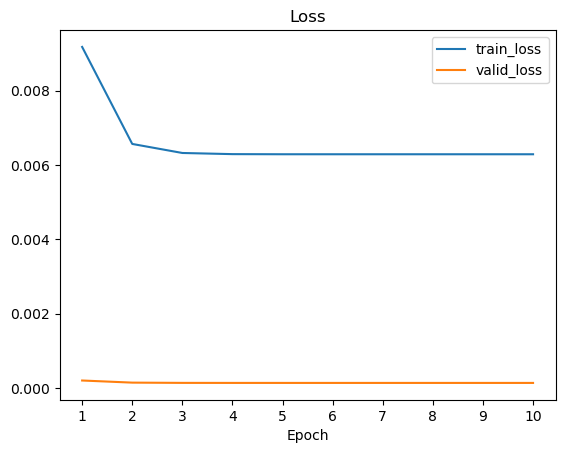

In [146]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train_loss')
plt.plot(valid_loss, label='valid_loss')
plt.xticks(list(range(0, len(train_loss))), list(range(1, len(train_loss)+1)))
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

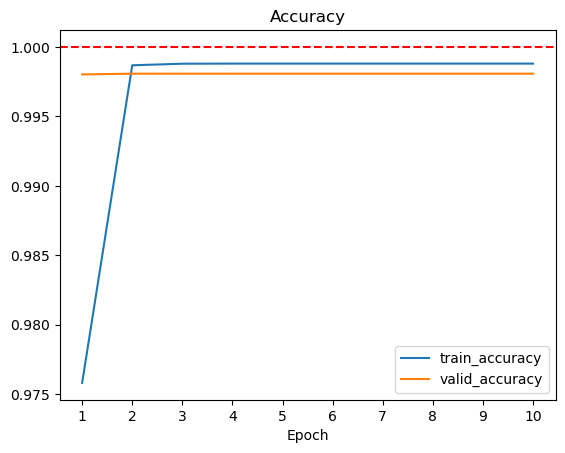

In [147]:
plt.plot(train_acc, label='train_accuracy')
plt.plot(valid_acc, label='valid_accuracy')
plt.axhline(y=1, color='red', linestyle='--')   # axis horizontal line
plt.xticks(list(range(0, len(train_loss))), list(range(1, len(train_loss)+1)))
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()